In [1]:
import os

import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
import numpy as np
import csv
from script.DHOV.Sampling.PerGroupLineSearchSampling import PerGroupLineSearchSamplingStrategy
from script.DHOV.Sampling.PerGroupSamplingStrategy import PerGroupSamplingStrategy
from script.DHOV.Sampling.PerGroupFeasibleSamplingStrategy import PerGroupFeasibleSamplingStrategy
from script.DHOV.Sampling.ZonotopeSamplingStrategy import ZonotopeSamplingStrategy

In [2]:
import onnx
from onnx2pytorch import ConvertModel
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

from vnnlib.compat import read_vnnlib_simple
from collections import OrderedDict

In [3]:
onnx_name = "mnist_relu_9_200.onnx"
vnnlib_name = "1000_mnist_eps_015"

onnx_path = 'nets/' + onnx_name
onnx_path = "../mnist-net_256x4.onnx"
vnnlib_dir_path = "specs/" + vnnlib_name

# Import the onnx model and convert it to a SequentialNN
It has to bee a SequentialNN

The SequentialNN needs to have one additional output layer, as its last layer never has relu activation but the imported network has. The last layer then gets initialized with the identity matrix and gets skipped during the verification

In [4]:
onnx_model = onnx.load(onnx_path)
pytorch_model = ConvertModel(onnx_model)
# nn = SequentialNN([28 * 28 * 1, 200, 200, 200, 200, 200, 200, 200, 200, 10, 10])
nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])

state_dict = pytorch_model.state_dict()
my_state_dict = {}
for i, key in enumerate(state_dict):
    actual_index = i * 2
    my_state_dict[f"{actual_index}.bias"] = state_dict[f"_initializer_layers_{actual_index}_bias"]
    my_state_dict[f"{actual_index}.weight"] = state_dict[f"_initializer_layers_{actual_index}_weight"]
    if actual_index == 8:
        break
    
nn.load_state_dict(my_state_dict)

"""parameter_list_onnx = list(pytorch_model.parameters())
parameter_list_sequential = list(nn.parameters())
for i in range(0, len(parameter_list_onnx), 2):
    parameter_list_sequential[i].data = parameter_list_onnx[i].data
    parameter_list_sequential[i+1].data = parameter_list_onnx[i+1].data
parameter_list_sequential[-2].data = torch.eye(10, dtype=data_type)
parameter_list_sequential[-1].data = torch.zeros(10, dtype=data_type)"""

/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


'parameter_list_onnx = list(pytorch_model.parameters())\nparameter_list_sequential = list(nn.parameters())\nfor i in range(0, len(parameter_list_onnx), 2):\n    parameter_list_sequential[i].data = parameter_list_onnx[i].data\n    parameter_list_sequential[i+1].data = parameter_list_onnx[i+1].data\nparameter_list_sequential[-2].data = torch.eye(10, dtype=data_type)\nparameter_list_sequential[-1].data = torch.zeros(10, dtype=data_type)'

In [5]:
parameter_list = list(pytorch_model.parameters()) # don't use nn here as we have added an extra layer
output_size = 10
number_layer = (len(parameter_list) - 2) // 2

# Load the data to apply the verification process for

In [6]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [7]:
transform = Compose([ToTensor()])
training_data = MNIST(root="../../../mnist", train=True, download=True, transform=transform)

In [8]:
def accuracy_test(model, converted_model, data):
    total_correct = 0
    total_wrong = 0
    for image, label in data:
        test_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)   
        model_test = model(test_image)
        converted_test = converted_model(test_image)
        if not torch.isclose(model_test, converted_test).all():
            print("is not close")
            break
        if torch.argmax(model_test).item() == label:
            total_correct += 1
        else:
            total_wrong += 1
    
    print("is close")    
    print(f"accuracy {total_correct/ len(training_data)}")
    


do_test = False
if do_test:
    accuracy_test(pytorch_model, nn, training_data)


In [9]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    """
    
    :param model: the optimization problem in gurobi encoding the NN
    :param nn_layer_out_bounds: torch.Tensor, approximating the upper and lower bounding the output layer of the NN
    :param label: index of the label or target neuron which is compared against
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :param sovler_bound: provides a bound for the gurobi solver. If this bound is achieved, the optimizer stops
    """
    
    out_lb = nn_layer_out_bounds[-1][0].detach().cpu().numpy()
    out_ub = nn_layer_out_bounds[-1][1].detach().cpu().numpy()
    
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    
    difference_lb.pop(label)
    difference_ub.pop(label)
    
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)
    
    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    if sovler_bound != None:
        model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)

In [10]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [23]:
def optimize_model(model, output_vars, start_overall_time, time_limit=60*60, verbose=True, csv_to_write_to=None, csv_row_name="No name"):
    """
    
    :param model: the optimization problem in gurobi encoding the NN and the objective 
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :return True if verification was successful, else false 
    """
    
    model.setParam("TimeLimit", time_limit)
    
    start_solving_time = time.time()
    model.update()
    model.optimize()
    
    end_time = time.time()
    time_just_solving = end_time - start_solving_time
    time_overall = end_time - start_overall_time
    
    if verbose:
        print("time for verification {}".format(time_just_solving))
        print("overall time {}".format(time_overall))
    
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
    
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        
        verification_successful = max_var < 0
        
        if verbose:
            if verification_successful:
                print("property verified with max difference {}".format(max_var))
                return True
            else:
                 print("property NOT verified with max difference {}".format(max_var))
                
                
        if csv_to_write_to is not None:
            new_row = [csv_row_name, "finished", time_just_solving, time_overall, verification_successful, max_var]
            with open(csv_to_write_to, 'a', newline='') as file_obj:
                writer_object = csv.writer(file_obj)
             
                writer_object.writerow(new_row)
                file_obj.close()
        
        return verification_successful
    
    elif model.Status == grp.GRB.TIME_LIMIT:        
        
        max_var_upper_bound = model.getVarByName("max_var").getAttr("UB")
        
        verification_failed_with_upper_bound = max_var_upper_bound > 0
        
        if verbose:
            if verification_failed_with_upper_bound:
                print("property NOT verified with upper bound for max difference {}".format(max_var_upper_bound))
            else:
                print("time out and upper bound could not disprove the setting")
            
        if csv_to_write_to is not None:
            new_row = [csv_row_name, "time_out", time_just_solving, time_overall, verification_failed_with_upper_bound, max_var_upper_bound]
            with open(csv_to_write_to, 'a', newline='') as file_obj:
                writer_object = csv.writer(file_obj)
             
                writer_object.writerow(new_row)
                file_obj.close()
                
                
        return verification_failed_with_upper_bound

    elif model.Status == grp.GRB.INFEASIBLE:
        end_time = time.time()
        
        if csv_to_write_to is not None:
            new_row = [csv_row_name, "infeasible", time_just_solving, time_overall, False]
            with open(csv_to_write_to, 'a', newline='') as file_obj:
                writer_object = csv.writer(file_obj)
             
                writer_object.writerow(new_row)
                file_obj.close()
        
        if verbose:
            print("model infeasible")
    
            model.computeIIS()
            print("constraint")
            all_constr = model.getConstrs()
    
            for const in all_constr:
                if const.IISConstr:
                    print("{}".format(const))
    
            print("lower bound")
            all_var = model.getVars()
            for var in all_var:
                if var.IISLB:
                    print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))
    
            print("upper bound")
            all_var = model.getVars()
            for var in all_var:
                if var.IISUB:
                    print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))
                
        

    return False

In [12]:
def load_vnnlib_bounds(vnnlib_path, input_shape, n_out):
    n_in = np.prod(input_shape)
    res = read_vnnlib_simple(vnnlib_path, n_in, n_out)
    bnds, spec = res[0]
    
    bnds = np.array(bnds)
    lbs = bnds[:,0]
    ubs = bnds[:,1]
    
    data_min = torch.tensor(lbs, dtype=data_type).reshape(input_shape).to(device)
    data_max = torch.tensor(ubs, dtype=data_type).reshape(input_shape).to(device)

    return [data_min, data_max]

# get bounds with crown

In [13]:
def onnx_to_bounded_model(onnx_path, input_shape):
    onnx_model = onnx.load(onnx_path)
    torch_model = ConvertModel(onnx_model)
    
    x_concrete = torch.zeros(input_shape)
    model = BoundedModule(torch_model, x_concrete)
    return model

In [14]:
def load_vnnlib_spec_for_auto_lirpa(vnnlib_path, input_shape, n_out):
    n_in = np.prod(input_shape)
    res = read_vnnlib_simple(vnnlib_path, n_in, n_out)
    bnds, spec = res[0]
    
    bnds = np.array(bnds)
    lbs = bnds[:,0]
    ubs = bnds[:,1]
    
    data_min = torch.tensor(lbs, dtype=data_type).reshape(input_shape)
    data_max = torch.tensor(ubs, dtype=data_type).reshape(input_shape)
    center = 0.5*(data_min + data_max)

    ptb = PerturbationLpNorm(x_L=data_min, x_U=data_max)
    x = BoundedTensor(center, ptb)
    
    return x, center

In [15]:
def get_layers(model):
    return [l for l in model.nodes() if l.perturbed]

In [16]:
def get_intermediate_bounds(model):
    """
    Returns a dictionary containing the concrete lower and upper bounds of each layer.
    
    Implemented own method to filter out bounds for weight matrices.
    
    Only call this method after compute_bounds()!
    """
    od = OrderedDict()
    for l in get_layers(model):
        if hasattr(l, 'lower'):
            od[l.name] = (l.lower, l.upper)
            
    return od

In [17]:
def get_bounds_auto_lirpa(x: BoundedTensor, model: BoundedModule):
    model.compute_bounds(x=(x,), method='crown')
    bounds_dict_crown = get_intermediate_bounds(model)
    crown_bounds_affine_out = []
    for i, key in enumerate(bounds_dict_crown.keys()):
        if i == 0: # use this if ibp is used (or i % 2 == 1:)
            continue
        lb, ub = bounds_dict_crown[key]
        crown_bounds_affine_out.append([lb.type(data_type).view(-1).to(device), ub.type(data_type).view(-1).to(device)])
        
    crown_bounds_layer_out = []
    relu = torch.nn.ReLU()
    for i, (lb, ub) in enumerate(crown_bounds_affine_out):
        if i == len(crown_bounds_affine_out) - 1:
            crown_bounds_layer_out.append([lb, ub])
        else:
            lb_layer = relu(lb)
            ub_layer = relu(ub)
            crown_bounds_layer_out.append([lb_layer, ub_layer])
            
    return crown_bounds_affine_out, crown_bounds_layer_out

# Create new csv

In [27]:
data = [['Input name', 'State of optimization', 'time for just solving', "time overall", "was successful?", "max distance"]]
# File path for the CSV file
csv_file_path = 'results_{}_{}.csv'.format(onnx_name, vnnlib_name)

# Open the file in write mode
with open(csv_file_path, mode='a+', newline='') as file_obj:
    # Create a csv.writer object
    writer_object = csv.writer(file_obj)
    # Write data to the CSV file
    writer_object.writerows(data)
 
# Print a confirmation message
print(f"CSV file '{csv_file_path}' created successfully.")

CSV file 'results_mnist_relu_9_200.onnx_1000_mnist_eps_015.csv' created successfully.


In [78]:
def check_if_image_is_labeled_correctly(nn_model, image, label):
    test_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
    output = nn_model(test_image)
    return torch.argmax(output).item() == label

In [79]:
def check_if_auto_lirpa_already_verifies(x, output_size, label):
    c_matrix = torch.zeros((1, output_size - 1, output_size))
    for i in range(output_size - 1):
        if i < label:
            index = i
        elif i >= label:
            index = i + 1
        
        c_matrix[0][i][index] = 1
        c_matrix[0][i][label] = -1
    
    lb, ub = model.compute_bounds(x=(x,), C=c_matrix, method='crown')
    
    return ub.max() < 0

# Do Verification SNR with MILP in last layer

0 ================================================


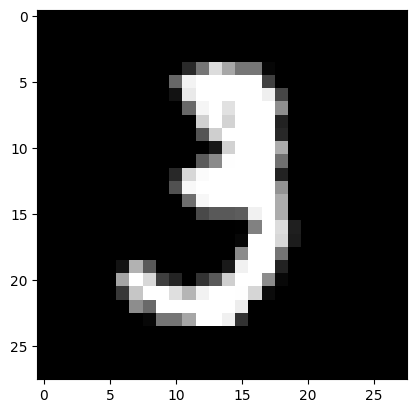

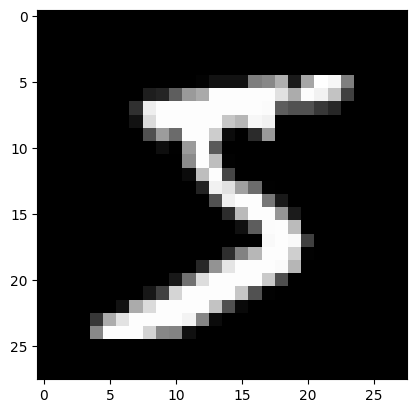

KeyboardInterrupt: 

In [85]:
for num, vnnlib_path in enumerate(sorted(os.listdir(vnnlib_dir_path))):
    
    
    print("{} ================================================".format(num))
    
    full_path = vnnlib_dir_path + "/" + vnnlib_path
    input_bounds = load_vnnlib_bounds(full_path, [784,], 10)
    model = onnx_to_bounded_model(onnx_path, [1,1,1,784])
    image, label = training_data[num]
    x, center = load_vnnlib_spec_for_auto_lirpa(full_path, [1,1,1,784], 10)
    
    imshow(center.view(28, 28))
    imshow(image.view(28, 28))
    
    if not check_if_image_is_labeled_correctly(nn, image, label):
        print("skipped because wrong classification from the network")
        
        new_row = [vnnlib_path, "wrong classification"]
        with open(csv_file_path, 'a', newline='') as file_obj:
            writer_object = csv.writer(file_obj)
         
            writer_object.writerow(new_row)
            file_obj.close()
            
            
        continue
    
    if check_if_auto_lirpa_already_verifies(x, 10, label):
        print("skipped because auto lirpa already verified")
        
        new_row = [vnnlib_path, "lirpa classified"]
        with open(csv_file_path, 'a', newline='') as file_obj:
            writer_object = csv.writer(file_obj)
         
            writer_object.writerow(new_row)
            file_obj.close()
            
        continue
    break
    
    overall_time = time.time()
    # weirdly the box bounds are faster for snr+milp
    bounds_affine_out, bounds_layer_out = get_bounds_auto_lirpa(x, model)
    
    # we need to pick these parameters, but for the SNR+MILP case these don't matter
    sampling_strategy = PerGroupLineSearchSamplingStrategy(center, input_bounds, nn, sample_count=100)
    group_size = 20
    net_size = [5, 1]
    icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)
    
    
    
    dhov_verifier = multidhov.MultiDHOV()
    dhov_verifier.start_verification(nn, center, icnn_factory, group_size, input_bounds, sampling_strategy, init_affine_bounds=bounds_affine_out, init_layer_bounds=bounds_layer_out,
                                     skip_last_layer=False, #todo change this too true
                                     tighten_bounds=False, layers_as_snr=[0, 1, 2], layers_as_milp=[3])
    
    print("creating model time: {}".format(time.time() - overall_time))
    
    dhov_model = dhov_verifier.nn_encoding_model.copy()
    dhov_model.update()
    dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)
    
    add_output_constraints(dhov_model, dhov_verifier.bounds_layer_out, label, dhov_out_vars, sovler_bound=10)
    
    optimize_model(dhov_model, dhov_out_vars, overall_time, verbose=True, csv_to_write_to=csv_file_path, csv_row_name=vnnlib_path)

# Do DHOV Verification

In [19]:
for num, vnnlib_path in enumerate(sorted(os.listdir(vnnlib_dir_path))):
    
    if num == 1:
        break
    
    print("{} ================================================".format(num))
    
    full_path = vnnlib_dir_path + "/" + vnnlib_path
    input_bounds = load_vnnlib_bounds(full_path, [784,], 10)
    model = onnx_to_bounded_model(onnx_path, [1,1,1,784])
    _, label = training_data[num]
    x, center = load_vnnlib_spec_for_auto_lirpa(full_path, [1,1,1,784], 10)
    
    overall_time = time.time()
    # weirdly the box bounds are faster for snr+milp
    bounds_affine_out, bounds_layer_out = get_bounds_auto_lirpa(x, model)
    
    
    sampling_strategy = PerGroupLineSearchSamplingStrategy(center, input_bounds, nn, sample_count=3000)
    group_size = 20
    net_size = [5, 1]
    #icnn_factory = ICNNFactory("approx_max", net_size, maximum_function="SMU", function_parameter=0.3)
    icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)
    #icnn_factory = ICNNFactory("standard", net_size, adapt_layer_for_init=True)
    
    
    
    dhov_verifier = multidhov.MultiDHOV()
    dhov_verifier.start_verification(nn, center, icnn_factory, group_size, input_bounds, sampling_strategy, 
                                     init_affine_bounds=bounds_affine_out, 
                                     init_layer_bounds=bounds_layer_out,
                                     skip_last_layer=True, 
                                     icnn_epochs=200, 
                                     icnn_batch_size=10000, 
                                     use_over_approximation=True, 
                                     tighten_bounds=False, 
                                     use_fixed_neurons_in_grouping=False, 
                                     layers_as_snr=[4, 5, 6, 7], 
                                     layers_as_milp=[8], 
                                     force_inclusion_steps=3, 
                                     preemptive_stop=True, 
                                     grouping_method="consecutive", 
                                     group_num_multiplier=5,
                                     optimizer="SdLBFGS", 
                                     init_network=True, 
                                     adapt_lambda="included",
                                     encode_icnn_enlargement_as_lp=False, 
                                     encode_relu_enlargement_as_lp=False,
                                     break_after=None, print_training_loss=False, print_new_bounds=False, store_samples=False, print_optimization_steps=False, print_last_loss=False)
    
    print("creating model time: {}".format(time.time() - overall_time))
    
    dhov_model = dhov_verifier.nn_encoding_model.copy()
    dhov_model.update()
    dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)
    
    add_output_constraints(dhov_model, dhov_verifier.bounds_layer_out, label, dhov_out_vars, sovler_bound=10)
    
    optimize_model(dhov_model, dhov_out_vars, overall_time, verbose=True, csv_to_write_to=csv_file_path, csv_row_name=vnnlib_path)

0 ================================================

approximation of layer: 0
    number of fixed neurons for current layer: 161
        time for sampling: 0.007546186447143555
    layer progress, group 1 of 2 


/home/ufuk/Documents/Programming/ICNN_verification/script/DHOV/MultiDHOV.py:152: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "
/home/ufuk/Documents/Programming/ICNN_verification/script/Optimizer/sdlbfgs.py:83: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
/home/ufuk/Documents/Programming/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

        time for training: 2.314298629760742
        actual verification time 0.23364639282226562
        time for verification: 0.26055240631103516
    layer progress, group 2 of 2 
        time for training: 2.060849189758301
        actual verification time 0.18515825271606445
        time for verification: 0.21419644355773926

approximation of layer: 1
    number of fixed neurons for current layer: 106
        time for sampling: 6.169048070907593
    layer progress, group 1 of 5 
        time for training: 2.0949108600616455
        actual verification time 0.8409216403961182
        time for verification: 0.8729398250579834
    layer progress, group 2 of 5 
        time for training: 9.624271631240845


GurobiError: Element 0 of a double array is Nan.